<a href="https://colab.research.google.com/github/AnandShegde/pml_baselines/blob/main/PyStan/WeibullPoisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
try:
  import pystan
except:
  %pip install -qq pystan
  import pystan
import tensorflow as tf
import seaborn as sns
import numpy as np
import jax
import jax.numpy as jnp
!pip install tensorflow_probability
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import arviz as az

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [113]:
import pickle
file=open('/content/WeibullPoissonData/weibull_poisson','rb')
data=pickle.load(file)
file.close()
data

{'prior': {'k': 15, 'lambda': array([10.], dtype=float32)},
 'samples': array([15., 17., 11., ..., 11., 13., 10.], dtype=float32)}

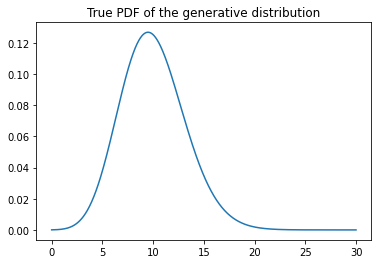

In [114]:
x_space = jnp.linspace(0,30,1000)
poisson = tfd.Poisson(rate=10)
true_pdf = poisson.prob(x_space)
plt.plot(x_space,true_pdf)
plt.title("True PDF of the generative distribution")
plt.show()

In [115]:
samples=data['samples']

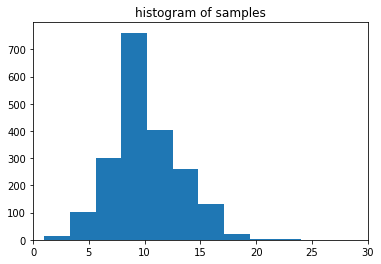

In [116]:
plt.hist(samples)
plt.xlim(0,30)
plt.title("histogram of samples")
plt.show()

In [117]:
WeibullPoisson = """
data {
  int<lower=0> n;
  int x[n];
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda~weibull(10,15);
  x~poisson(lambda);
}
"""

#**Using HMC(Hamiltonian Monte Carlo)**

In [118]:
model_WeibullPoisson = pystan.StanModel(model_code=WeibullPoisson)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3e60283f9b7d28dc8f1fce38d1f77d9d NOW.


In [119]:
data = {
    'n':  len(samples),
    'x': samples.astype(int),
}

In [120]:
model_weibull_hmc = model_WeibullPoisson.sampling(data=data, chains=8, warmup=500, iter=1500)

In [121]:
model_weibull_hmc

Inference for Stan model: anon_model_3e60283f9b7d28dc8f1fce38d1f77d9d.
8 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda  10.04  1.3e-3   0.07    9.9   9.99  10.04  10.09  10.18   3007    1.0
lp__    2.6e4    0.01   0.69  2.6e4  2.6e4  2.6e4  2.6e4  2.6e4   3879    1.0

Samples were drawn using NUTS at Sun Jun  5 10:11:45 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [122]:
lambda_hmc=(model_weibull_hmc.extract())['lambda'].mean()
lambda_hmc

10.039564298088326

In [135]:
# az.plot_trace(model_weibull_hmc, figsize = (12, 4))

In [134]:
# weibullhmc_df = model_weibull_hmc.to_dataframe()
# weibullhmc_df

# **Using Variational Inference(VI)**

In [125]:
model_Weibull_vi=model_WeibullPoisson.vb(data=data)

In [126]:
# model_bernoulli_vi

In [127]:
lambda_vi=model_Weibull_vi.get('mean_pars')
lambda_vi

[10.393394543756473]

In [133]:
# az.plot_trace(data=np.array(model_Weibull_vi.get('sampler_params')[0]), figsize = (12, 4))

#**Plotting the distributions**


/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4457: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


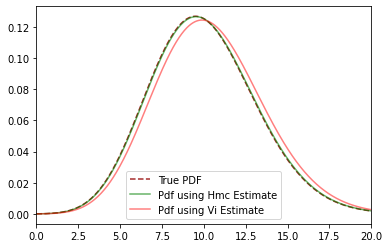

In [146]:
plt.plot(x_space,true_pdf,label='True PDF',color='brown',alpha=1,linestyle='dashed')

pois = tfd.Poisson(rate = lambda_hmc)
sample_pdf_hmc = pois.prob(x_space)
plt.plot(x_space,sample_pdf_hmc,color='g',alpha=0.6,label='Pdf using Hmc Estimate')

pois = tfd.Poisson(rate = lambda_vi)
sample_pdf = pois.prob(x_space)
plt.plot(x_space,sample_pdf,color='r',alpha=0.5,label='Pdf using Vi Estimate')
plt.xlim(0,20)
plt.legend()
plt.show()